In [8]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from catboost import CatBoostClassifier
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
import nltk
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")

data = pd.read_csv("data/Twitter_Data.csv")

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Preparing data

shape with NaN values: (162980, 2)
(162969, 2)
shape without NaN values: (162969, 2)


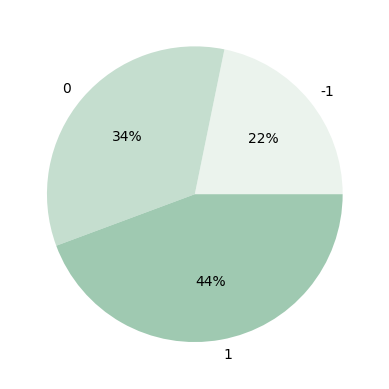

In [9]:
print(f"shape with NaN values: {data.shape}")
data = data.dropna()
print(data.shape)

print(f"shape without NaN values: {data.shape}")

data.head()

reviews = ["-1", "0", "1"]
number_of_reviews = [data['category'].value_counts()[x] for x in range(-1, 2)]

#define Seaborn color palette to use
colors = sns.light_palette('seagreen')[0:3]

#create pie chart
plt.pie(number_of_reviews, labels=reviews, colors=colors, autopct='%.0f%%')
plt.show()

In [10]:
def delete_punctuation_from_string(s: str):
    return re.sub(r'[^\w\s]', '', s)


data.loc[:, "clean_text"] = data["clean_text"].astype(str)
data.loc[:, "clean_text"] = data["clean_text"].apply(delete_punctuation_from_string)

train, test = train_test_split(data, random_state=239)

In [11]:
bow = CountVectorizer()

x_train = bow.fit_transform(train["clean_text"])
x_test = bow.transform(test["clean_text"])
y_train = train["category"]
y_test = test["category"]

import time

t = time.time()
cbc = CatBoostClassifier(task_type='GPU', learning_rate=0.3, iterations=500)
cbc.fit(x_train, y_train, verbose=False)
print(time.time() - t)

# 116.26442384719849
# 0.9301598458959877

# 113.65503215789795 0.3 / 1000
# 0.9374714628447963

# 152.65503215789795 0.3 / 1500
# 0.9374714628447963

# 155.61173748970032
# 0.9399550699946421

# 95.837233543396
# 0.8826353364534069

y_pred = cbc.predict(x_test)

print(balanced_accuracy_score(y_pred, y_test))

50.541255474090576
0.9275236275277732


### Preprocessing data better

It appeared that in case either lemmatization or deleting stopwords is applied, the accuracy is noticeably higher than with both approaches applied. Will be used just lemmatization (or maybe ensembling with stacking)

In [ ]:
l = WordNetLemmatizer()


def lemmatize(x):
    x = map(lambda r: ' '.join([l.lemmatize(i.lower()) for i in r.split()]), x)
    x = np.array(list(x))
    return x


stop_words = stopwords.words('english')


def delete_stop_word(s):
    words = s.split()
    return " ".join([word for word in words if word.lower() not in stop_words])


# apply lemmatization
train["clean_text"] = lemmatize(train["clean_text"])
test["clean_text"] = lemmatize(test["clean_text"])

# delete stop words
train_no_sw = train["clean_text"].apply(delete_stop_word)
test_no_sw = test["clean_text"].apply(delete_stop_word)

bow = CountVectorizer()

x_train = bow.fit_transform(train_no_sw)
x_test = bow.transform(test_no_sw)
y_train = train["category"]
y_test = test["category"]

GridSearch suggests that iterations=1500, depth=9 and learning_rate=0.3 are optimal hyperparameters with test score accuracy: 0.8937240753012787. But even with iterations=9 and learning_rate=0.3 - all is ok (accuracy: 0.92)

In [ ]:
cb_model = CatBoostClassifier(verbose=False)

cb_param_grid = {
    'iterations': [500, 1000, 1500],
    'depth': [3, 5, 7, 9],
    'learning_rate': [0.1, 0.15, 0.2, 0.3],
}

cb_gs = GridSearchCV(estimator=cb_model, param_grid=cb_param_grid, cv=3, n_jobs=-1, verbose=3)

cb_gs.fit(x_train, y_train)

print("Best parameters:", cb_gs.best_params_)
print("Best score:", cb_gs.best_score_)

best_model = cb_gs.best_estimator_
test_score = best_model.score(x_test, y_test)
print("Test set score:", test_score)

In [ ]:
clf = CatBoostClassifier(iterations=1500, learning_rate=0.3, task_type='GPU', verbose=True)
clf.fit(x_train, y_train)

# lemmatized + without stopwords -> 0.89
# lemmatized -> 0.926
# without stopwords -> 0.9023

y_pred = clf.predict(x_test)

print("CatBoost", balanced_accuracy_score(y_pred, y_test))

In [ ]:
logr = LogisticRegression(verbose=True)
logr.fit(x_train, y_train)

# lemmatized + without stopwords -> 0.884258
# lemmatized -> 0.925
# without stopwords -> 0.89744

y_pred = logr.predict(x_test)

print("Logistic", balanced_accuracy_score(y_pred, y_test))

In [ ]:
log_r_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}

# Logistic regression hyper-param tuning
logr_gs = GridSearchCV(estimator=LogisticRegression(), param_grid=log_r_param_grid, cv=5, n_jobs=-1, verbose=3)
logr_gs.fit(x_train, y_train)

# for lemmatized
# Best score: 0.92647
# Best params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'} 

# without stopwords
# Best score: 0.9018457653217304
# Best params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

# lemmatized + no stopwords
# Best score: 0.8887225379954671
# Best params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

print("Best score:", logr_gs.best_score_)
print("Best params:", logr_gs.best_params_)

In [ ]:
rf = RandomForestClassifier(verbose=True, n_jobs=-1)
rf.fit(x_train, y_train)

# lemmatized + without stopwords -> 0.84985
# lemmatized -> 0.8482033
# without stopwords -> 0.8480635

y_pred = rf.predict(x_test)

print("Random forest", balanced_accuracy_score(y_pred, y_test))

In [ ]:
# Computationally demanding. Will not tune paramemters

rf_grid_params = {'max_features': [1, 3, 5, 7],
                  'min_samples_leaf': [1, 2, 3],
                  'min_samples_split': [1, 2, 3]
                  }

rf_hype = RandomForestClassifier(verbose=False, n_jobs=-1)

rf_gs = RandomizedSearchCV(estimator=rf_hype, param_distributions=rf_grid_params, cv=5, verbose=3)
rf_gs.fit(x_train, y_train)

print("Best score:", rf_gs.best_score_)
print("Best params:", rf_gs.best_params_)

Tried LogisticRegression and RandomForestClassifier with no hyperparameter tuning and both display a reasonable accuracy: LR - 0.89744, RF - 0.86577


# SAVE CATBOOST MODEL

In [12]:
import pickle

# cbc = CatBoostClassifier()
with open("models/model_catboost", 'wb') as model_file:
    pickle.dump((cbc, bow), model_file)

# USAGE

In [1]:
from interactor import Interactor

In [2]:
ModelsObj = Interactor(models_path="models")

In [3]:
ModelsObj.predict(model_name="catboost", sentence="AMAZING I LOVE YOU ALL THERE")

array([[1.]])